In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import sys
import os
import time

# ### settings for running training loop using a specified Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = "/content/gdrive/MyDrive/"

### Hardware agnostic settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use is: ", device)

root = gdrive_path + ''
sys.path.append(root + 'Code/')
sys.path.append(root + 'Code/Training')
sys.path.append(root + 'Code/Models')

import Plots_Tools as PT
import Train_Tools as Train
import LipschitzRNN as LRNN
import NeuralODE as NODE
import SVDCombo as SVDC
import GC_SVDCombo as GC_SVDC
import LurieNet as LN
import kLurieNet_nonHurwitz as LN_k # use kLurieNet_Hurwitz for k=1, k=2 examples and kLurieNet_nonHurwitz for k=3
import GLN_nonHurtwitz as GLN # use GLN_Hurtwitz for k=1, k=2 examples and GLN_nonHurtwitz for k=3
import AntisymmetricRNN as ARNN

Mounted at /content/gdrive
Device in use is:  cuda


### Training

In [ ]:

# ####################################### user settings #############################################

# data
D = '1a' # Dataset number
data_path = root + 'Data/Dataset{0}/'.format(D)
batch = 10
bs = 100
test_split = 0.1
rseed = np.random.randint(0,100)
n = 3 # state dimension
q = 1 # number of graph coupled networks

# model
exp_no = 1 # experiment number
model_name = 'ARNN/'
model_dir = root + 'Models/' + model_name + 'Exp_{:03d}/'.format(exp_no)

if model_name == 'LurieNet_k/' or model_name == 'GLN/':
    A_type = 'full'
    B = None
    C = None
    bx = None
    by = None
    g = 1
    k = 3
elif model_name == 'LurieNet/':
    bx = None
    by = None
elif model_name == 'SVD_Combo/' or model_name == 'GC_SVDC/':
    g = 1
    bx = None
elif model_name == 'LipschitzRNN/':
    by = None
elif model_name == 'ARNN/':
    by = None
elif model_name == 'NeuralODE/':
    h = 100

# training
max_epoch = 100
lr = 1e-2
wd = 1e-5
decay = 1/3
decay_epochs = []

###################################################################################################

if os.path.isdir(model_dir):
    raise Exception("File already exists! Do not overwrite")
else:
    os.makedirs(model_dir)

torch.manual_seed(rseed)

# (batch, bs, tmax, n)
X_train, X_test, T, exp_setup = Train.get_data(data_path, batch, bs, test_split, rseed, device)

# # include for datasets 1a, 2a where equilibrium points are known.
# try:
#     eqs = torch.from_numpy( exp_setup['eqs'] )
# except:
#     eqs = exp_setup['eqs']

_, _, step = exp_setup['time']

_, _, tmax, _ = X_test.shape # (test_batch, bs, tmax, n)

if model_name == 'LurieNet/':
    print('LurieNet chosen as model!')
    model = LN.LurieNet(q*n, tmax, step, bx, by)
elif model_name == 'LurieNet_k/':
    print('LurieNet_k chosen as model!')
    model = LN_k.LurieNet_k(q*n, tmax, step, g, k, A_type, B, C, bx, by)
elif model_name == 'GLN/':
    print('GLN chosen as model!')
    model = GLN.GLN(q, n, tmax, step, g, k, A_type, B, C, bx, by)
elif model_name == 'LipschitzRNN/':
    print('LipschitzRNN chosen as model!')
    model = LRNN.LipschitzRNN(q*n, tmax, step, by)
elif model_name == 'ARNN/':
    print('ARNN chosen as model!')
    model = ARNN.AntisymmetricRNN(q*n, tmax, step, by)
elif model_name == 'SVD_Combo/':
    print('SVD_Combo chosen as model!')
    model = SVDC.SVD_Combo(q*n, tmax, step, g, bx)
elif model_name == 'GC_SVDC/':
    print('GC_SVDC chosen as model!')
    model = GC_SVDC.GC_SVDC(q, n, tmax, step, g, bx)
elif model_name == 'NeuralODE/':
    print('NeuralODE chosen as model!')
    model = NODE.ODEBlock( NODE.ODEFunc(q*n, h) )

run_settings = {'D':D, 'batch':batch, 'bs':bs, 'test_split':test_split, 'rseed':rseed, \
                'max_epoch':max_epoch, 'lr':lr, 'wd':wd, 'decay':decay, 'decay_epochs':decay_epochs}

if model_name == 'LurieNet/':
    model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'bx':bx, 'by':by}
elif model_name == 'LurieNet_k/':
    model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'g':g, 'k':k, 'A_type':A_type, 'B':B, 'C':C, 'bx':bx, 'by':by}
elif model_name == 'GLN/':
    model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'g':g, 'k':k, 'A_type':A_type, 'B':B, 'C':C, 'bx':bx, 'by':by}
elif model_name == 'SVD_Combo/':
    model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'g':g, 'bx':bx}
elif model_name == 'GC_SVDC/':
    model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'g':g, 'bx':bx}
elif model_name == 'LipschitzRNN/':
    model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'by':by}
elif model_name == 'ARNN/':
  model_params = {'q':q, 'n':n, 'tmax':tmax, 'step':step, 'by':by}
elif model_name == 'NeuralODE/':
    model_params = {'q':q, 'n':n, 'h':h}

with open(model_dir+'run_settings.pkl', 'wb') as f:
    pickle.dump(run_settings, f)
    f.close()
with open(model_dir+'model_params.pkl', 'wb') as f:
    pickle.dump(model_params, f)
    f.close()

print( 'parameter count =', sum(p.numel() for p in model.parameters() if p.requires_grad) )
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = nn.MSELoss()

start_time = time.time()
print( "--- %s seconds ---" % (start_time) )

model = model.to(device)
model, stats = Train.train(X_train, X_test, T, model, optimizer, criterion, max_epoch, model_dir,
               decay, decay_epochs, model_name, device)

exe_time = time.time() - start_time
print( "--- %s seconds ---" % (exe_time) )


run_settings = {'D':D, 'batch':batch, 'bs':bs, 'test_split':test_split, 'rseed':rseed, \
                'max_epoch':max_epoch, 'lr':lr, 'wd':wd, 'decay':decay, 'decay_epochs':decay_epochs,
                'exe_time':exe_time}

with open(model_dir+'run_settings.pkl', 'wb') as f:
    pickle.dump(run_settings, f)
    f.close()



ARNN chosen as model!
parameter count = 12
--- 1733235598.7578845 seconds ---
Epoch 1/2 - Train loss: 0.336 - Test loss: 0.317
Epoch 2/2 - Train loss: 0.324 - Test loss: 0.311
--- 17.108701467514038 seconds ---


### Data analysis from last run

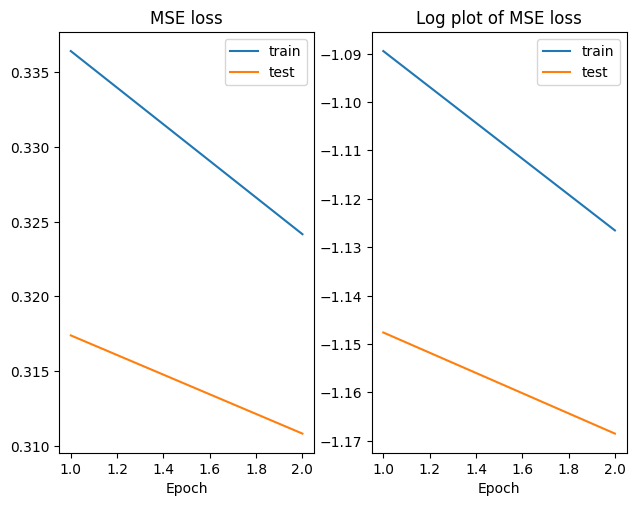

0

In [7]:
file = 'mse'
PT.plot_mse(model_dir, file, stats, max_epoch)


In [8]:
# Plots.

file = 'compare_train_traj'
model = ARNN.AntisymmetricRNN(q*n, tmax, step, by)

best_model_index = np.argmin(stats['test loss'])
best_model = 'epoch{:03d}.pt'.format(best_model_index+1)
model.load_state_dict( torch.load(model_dir + best_model) )
model = model.to("cpu")
T = T.to("cpu")
X_train = X_train.to("cpu")
preds = Train.batch_preds(model, X_train, T, model_name) # (batch, bs, tmax, n)

print('best model was %d with test loss %.3f' % (best_model_index, np.min(stats['test loss'])) )

print( sum(p.numel() for p in model.parameters() if p.requires_grad) )

<ipython-input-8-e347e322cb2e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load(model_dir + best_model) )


best model was 1 with test loss 0.311
12


IndexError: index 3 is out of bounds for dimension 3 with size 3

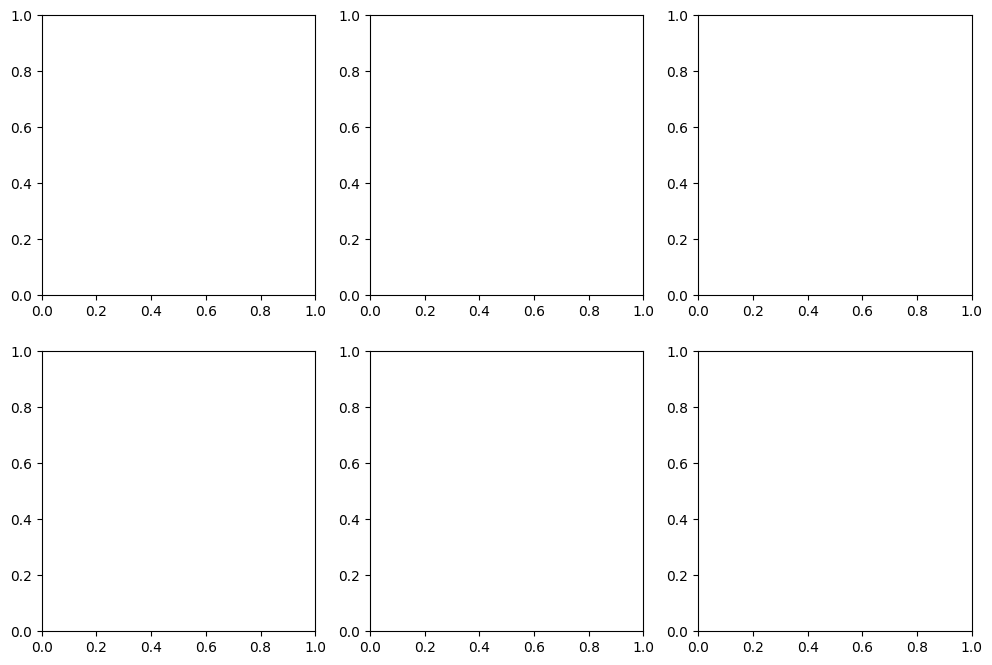

In [9]:
Q = 6 # number of trajectories to plot.
a = np.random.randint(bs, size=Q) # randomly sample Q out of N trajectories.
z = n*1 # for plotting different states

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

for j in range(Q):
  ax1.plot(T, X_train[0, a[j],:,0+z])
  ax2.plot(T, X_train[0, a[j],:,1+z])
  ax3.plot(T, X_train[0, a[j],:,2+z])
  ax4.plot(T, preds[0,a[j],:,0+z])
  ax5.plot(T, preds[0,a[j],:,1+z])
  ax6.plot(T, preds[0,a[j],:,2+z])

IndexError: list index out of range

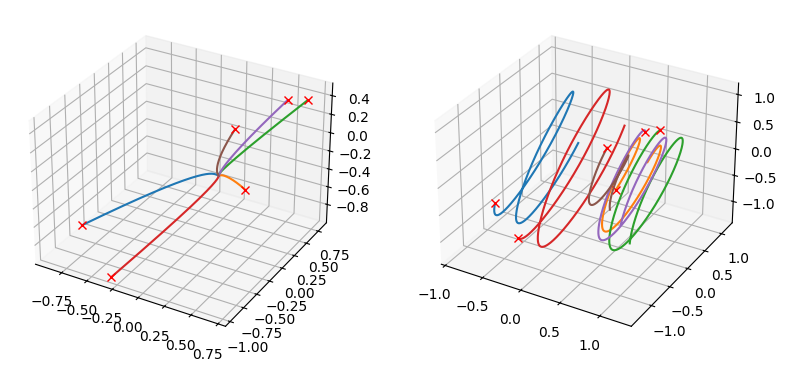

In [10]:
# Plot 3d states

# file = 'compare_train_traj'
# best_model_index = np.argmin(stats['test loss'])
# best_model = 'epoch{:03d}.pt'.format(best_model_index+1)
# model.load_state_dict( torch.load(model_dir + best_model) )
# preds = Train.batch_preds(model, X_train, T, model_name) # (batch, bs, tmax, n)

# if device == torch.device("cuda"):
#   T = T.cpu().numpy()
#   X_train = X_train.cpu().numpy()
#   preds = preds.cpu().numpy()
eqs = []
q = 6
PT.compare_traj(D, model_dir, file, X_train[:,:,:,:3], preds[:,:,:,:3], eqs, q)

print('best model was %d with test loss %.3f' % (best_model_index, np.min(stats['test loss'])) )
